In [25]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow_addons as tfa
import pickle
import pydot
import graphviz
from PIL import Image
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm

In [26]:
img_dim = (180, 180, 3)

imgs = []
labels = []

def resizer(img_paths):
  """
  모델에 사용할 수 있도록 이미지 사이즈 조정
  """
  for img_path in tqdm(img_paths):
      try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_dim[1], img_dim[0]))

        label = img_path.split(os.path.sep)[-2]
        labels.append([label])

        imgs.append(img)
      except:
        print(f"error file is {img_path.split('.')[-1]}")

In [27]:
images = '/Users/cmblir/Python/Phill-Detector/Model/Multi-Classification/image/images/'
train_img_paths = sorted(list(paths.list_images(images)))
print(">>> img counts =", len(train_img_paths))

>>> img counts = 21465


In [28]:
resizer(train_img_paths)

 13%|█▎        | 2844/21465 [00:15<01:49, 169.32it/s]

error file is png


100%|██████████| 21465/21465 [01:55<00:00, 185.67it/s]


In [29]:
imgs = np.array(imgs, dtype= 'float32') / 255.0
imgs_test = np.array(imgs, dtype= 'float32') / 255.0
labels = np.array(labels)

In [30]:
mlb = MultiLabelBinarizer()
enc_labels = mlb.fit_transform(labels)

In [31]:
print('>>> classes name =', mlb.classes_)

>>> classes name = ['X선조영제' 'nan' '소화성궤양용제' '정신신경용제' '각성제,흥분제' '간장질환용제'
 '갑상선, 부갑상선호르몬제' '강심제' '건위소화제' '골격근이완제' '구충제' '기생성 피부질환용제' '기타의 말초신경용약'
 '기타의 비뇨생식기관 및 항문용약' '기타의 비타민제' '기타의 소화기관용약' '기타의 순환계용약'
 '기타의 신경계및 감각기관용 의약품' '기타의 알레르기용약' '기타의 외피용약' '기타의 자양강장변질제' '기타의 조제용약'
 '기타의 조직세포의 기능용의약품' '기타의 종양치료제' '기타의 중추신경용약' '기타의 항생물질제제(복합항생물질제제를 포함)'
 '기타의 혈액 및 체액용약' '기타의 호르몬제(항호르몬제를 포함)' '기타의 호흡기관용약' '기타의 화학요법제'
 '난포호르몬제 및 황체호르몬제' '뇌하수체호르몬제' '단백동화스테로이드제' '단백아미노산제제' '당뇨병용제' '동맥경화용제'
 '따로 분류되지 않고 치료를 주목적으로 하지않는 의약품' '따로 분류되지 않는 대사성 의약품' '면역혈청학적 검사용 시약'
 '모발용제(발모, 탈모, 염모, 양모제)' '무기질제제' '백신류' '부신호르몬제' '부정맥용제'
 '비뇨생식기관용제(성병예방제포함)' '비타민 A 및 D제' '비타민 B1제' '비타민 B제(비타민 B1을 제외)'
 '비타민 C 및 P제' '비타민 E 및 K제' '비타민제' '설화제' '소화기관용약' '아편알카로이드계 제제' '안과용제'
 '이뇨제' '이담제' '이비과용제' '자격요법제(비특이성면역억제제를 포함)' '자궁수축제' '자율신경제' '장기제제'
 '저함량 비타민 및 미네랄 제제' '정장제' '제산제' '종합대사성제제' '주로 곰팡이, 원충에 작용하는 것'
 '주로 그람양성, 음성균, 리케치아, 비루스에 작용하는 것' '주로 그람양성, 음성균에 작용하는 것'
 '주로 그람양성균, 리케치아, 비루스에 작용하는 것' '주로 그람양성균에 작용하는 것' '

In [32]:
(X_train, X_test, y_train, y_test) = train_test_split(imgs, enc_labels, test_size = 0.2, random_state=42)

In [33]:
# 모델링
class Classifier:
	def build(width, height, depth, classes):
		model = Sequential()
		input_shape = (height, width, depth)
		
		model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))
  
		model.add(Conv2D(64, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
	
		model.add(Conv2D(64, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
 
		model.add(Conv2D(128, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
	
		model.add(Conv2D(128, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
        
		model.add(Conv2D(256, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
	
		model.add(Conv2D(256, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		model.add(Flatten())
		model.add(Dense(2048))
		model.add(Activation('relu'))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
  
		model.add(Dense(classes))
		model.add(Activation('softmax'))
		return model

In [34]:
# 모델 설정하기
model = Classifier.build(
    width=img_dim[1], height=img_dim[0], depth=img_dim[2],
    classes=len(mlb.classes_)
)

In [35]:
plot_model(model, to_file='model_shapes.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [36]:
# 학습 및 성능 측정하기
model.compile(loss = CategoricalCrossentropy(from_logits=False),
optimizer=Adam(learning_rate=1e-3, decay= 1e-3 / 200),
metrics = ['accuracy'])

In [37]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [38]:
# M! GPU 사용여부 확인
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [39]:
history = model.fit(
    X_train, y_train, batch_size = 32,
validation_data = (X_test, y_test),
epochs = 200, verbose = 1,
callbacks = [tqdm_callback]
)

Training:   0%|           0/200 ETA: ?s,  ?epochs/s

Epoch 1/200


0/537           ETA: ?s - 

Epoch 1/200


2022-10-16 02:00:48.338705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


537/537 [==============================] - ETA: 0s - loss: 3.6530 - accuracy: 0.1169

2022-10-16 02:04:37.562365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


537/537 [==============================] - 247s 457ms/step - loss: 3.6530 - accuracy: 0.1169 - val_loss: 85018368.0000 - val_accuracy: 0.1109
Epoch 2/200


0/537           ETA: ?s - 

Epoch 2/200
537/537 [==============================] - 240s 447ms/step - loss: 3.6060 - accuracy: 0.1171 - val_loss: 83802406912.0000 - val_accuracy: 0.1109
Epoch 3/200


0/537           ETA: ?s - 

Epoch 3/200
537/537 [==============================] - 244s 455ms/step - loss: 3.6050 - accuracy: 0.1178 - val_loss: 66935078912.0000 - val_accuracy: 0.0547
Epoch 4/200


0/537           ETA: ?s - 

Epoch 4/200
537/537 [==============================] - 245s 456ms/step - loss: 3.6029 - accuracy: 0.1186 - val_loss: 88477057024.0000 - val_accuracy: 0.1113
Epoch 5/200


0/537           ETA: ?s - 

Epoch 5/200
537/537 [==============================] - 244s 453ms/step - loss: 3.6022 - accuracy: 0.1184 - val_loss: 79921029120.0000 - val_accuracy: 0.1165
Epoch 6/200


0/537           ETA: ?s - 

Epoch 6/200
537/537 [==============================] - 246s 458ms/step - loss: 3.6037 - accuracy: 0.1174 - val_loss: 101718040576.0000 - val_accuracy: 0.1137
Epoch 7/200


0/537           ETA: ?s - 

Epoch 7/200
537/537 [==============================] - 246s 458ms/step - loss: 3.6009 - accuracy: 0.1186 - val_loss: 109824638976.0000 - val_accuracy: 0.1109
Epoch 8/200


0/537           ETA: ?s - 

Epoch 8/200
537/537 [==============================] - 246s 458ms/step - loss: 3.6001 - accuracy: 0.1188 - val_loss: 102087294976.0000 - val_accuracy: 0.0412
Epoch 9/200


0/537           ETA: ?s - 

Epoch 9/200
537/537 [==============================] - 248s 462ms/step - loss: 3.6009 - accuracy: 0.1185 - val_loss: 112056369152.0000 - val_accuracy: 0.0396
Epoch 10/200


0/537           ETA: ?s - 

Epoch 10/200
537/537 [==============================] - 246s 459ms/step - loss: 3.6004 - accuracy: 0.1186 - val_loss: 96178913280.0000 - val_accuracy: 0.1039
Epoch 11/200


0/537           ETA: ?s - 

Epoch 11/200
537/537 [==============================] - 246s 458ms/step - loss: 3.6001 - accuracy: 0.1186 - val_loss: 99428925440.0000 - val_accuracy: 0.1106
Epoch 12/200


0/537           ETA: ?s - 

Epoch 12/200
537/537 [==============================] - 252s 468ms/step - loss: 3.5997 - accuracy: 0.1186 - val_loss: 116857888768.0000 - val_accuracy: 0.1044
Epoch 13/200


0/537           ETA: ?s - 

Epoch 13/200
537/537 [==============================] - 235s 437ms/step - loss: 3.6010 - accuracy: 0.1187 - val_loss: 91041267712.0000 - val_accuracy: 0.0496
Epoch 14/200


0/537           ETA: ?s - 

Epoch 14/200
537/537 [==============================] - 234s 435ms/step - loss: 3.6014 - accuracy: 0.1185 - val_loss: 83907616768.0000 - val_accuracy: 0.1060
Epoch 15/200


0/537           ETA: ?s - 

Epoch 15/200
537/537 [==============================] - 237s 441ms/step - loss: 3.5986 - accuracy: 0.1186 - val_loss: 71678533632.0000 - val_accuracy: 0.0978
Epoch 16/200


0/537           ETA: ?s - 

Epoch 16/200
537/537 [==============================] - 240s 446ms/step - loss: 3.6002 - accuracy: 0.1186 - val_loss: 60121522176.0000 - val_accuracy: 0.0550
Epoch 17/200


0/537           ETA: ?s - 

Epoch 17/200
537/537 [==============================] - 238s 444ms/step - loss: 3.5999 - accuracy: 0.1182 - val_loss: 86732660736.0000 - val_accuracy: 0.1109
Epoch 18/200


0/537           ETA: ?s - 

Epoch 18/200
537/537 [==============================] - 236s 440ms/step - loss: 3.5990 - accuracy: 0.1186 - val_loss: 82954346496.0000 - val_accuracy: 0.0121
Epoch 19/200


0/537           ETA: ?s - 

Epoch 19/200
537/537 [==============================] - 236s 440ms/step - loss: 3.5982 - accuracy: 0.1186 - val_loss: 79369003008.0000 - val_accuracy: 0.0331
Epoch 20/200


0/537           ETA: ?s - 

Epoch 20/200
537/537 [==============================] - 234s 435ms/step - loss: 3.5989 - accuracy: 0.1186 - val_loss: 98391670784.0000 - val_accuracy: 0.0363
Epoch 21/200


0/537           ETA: ?s - 

Epoch 21/200
537/537 [==============================] - 233s 435ms/step - loss: 3.5991 - accuracy: 0.1186 - val_loss: 94609293312.0000 - val_accuracy: 0.0359
Epoch 22/200


0/537           ETA: ?s - 

Epoch 22/200
537/537 [==============================] - 233s 434ms/step - loss: 3.5984 - accuracy: 0.1186 - val_loss: 89592422400.0000 - val_accuracy: 0.0415
Epoch 23/200


0/537           ETA: ?s - 

Epoch 23/200
537/537 [==============================] - 233s 433ms/step - loss: 3.5992 - accuracy: 0.1186 - val_loss: 99831259136.0000 - val_accuracy: 0.0512
Epoch 24/200


0/537           ETA: ?s - 

Epoch 24/200
537/537 [==============================] - 237s 440ms/step - loss: 3.5983 - accuracy: 0.1186 - val_loss: 103630888960.0000 - val_accuracy: 0.0312
Epoch 25/200


0/537           ETA: ?s - 

Epoch 25/200
537/537 [==============================] - 236s 438ms/step - loss: 3.5984 - accuracy: 0.1186 - val_loss: 102060793856.0000 - val_accuracy: 0.0319
Epoch 26/200


0/537           ETA: ?s - 

Epoch 26/200
537/537 [==============================] - 235s 437ms/step - loss: 3.5994 - accuracy: 0.1186 - val_loss: 117572050944.0000 - val_accuracy: 0.0317
Epoch 27/200


0/537           ETA: ?s - 

Epoch 27/200
537/537 [==============================] - 234s 435ms/step - loss: 3.5967 - accuracy: 0.1186 - val_loss: 114956828672.0000 - val_accuracy: 0.0256
Epoch 28/200


0/537           ETA: ?s - 

Epoch 28/200
537/537 [==============================] - 234s 436ms/step - loss: 3.5987 - accuracy: 0.1186 - val_loss: 101572698112.0000 - val_accuracy: 0.0193
Epoch 29/200


0/537           ETA: ?s - 

Epoch 29/200
537/537 [==============================] - 234s 435ms/step - loss: 3.5979 - accuracy: 0.1186 - val_loss: 101467054080.0000 - val_accuracy: 0.0373
Epoch 30/200


0/537           ETA: ?s - 

Epoch 30/200
537/537 [==============================] - 233s 434ms/step - loss: 3.5977 - accuracy: 0.1186 - val_loss: 96006995968.0000 - val_accuracy: 0.0389
Epoch 31/200


0/537           ETA: ?s - 

Epoch 31/200
537/537 [==============================] - 233s 434ms/step - loss: 3.5972 - accuracy: 0.1186 - val_loss: 124492693504.0000 - val_accuracy: 0.0519
Epoch 32/200


0/537           ETA: ?s - 

Epoch 32/200
537/537 [==============================] - 236s 439ms/step - loss: 3.5973 - accuracy: 0.1186 - val_loss: 102383542272.0000 - val_accuracy: 0.0478
Epoch 33/200


0/537           ETA: ?s - 

Epoch 33/200
537/537 [==============================] - 234s 437ms/step - loss: 3.5976 - accuracy: 0.1186 - val_loss: 87048953856.0000 - val_accuracy: 0.0144
Epoch 34/200


0/537           ETA: ?s - 

Epoch 34/200
537/537 [==============================] - 235s 438ms/step - loss: 3.5981 - accuracy: 0.1186 - val_loss: 107230027776.0000 - val_accuracy: 0.0224
Epoch 35/200


0/537           ETA: ?s - 

Epoch 35/200
537/537 [==============================] - 234s 435ms/step - loss: 3.5988 - accuracy: 0.1186 - val_loss: 95735791616.0000 - val_accuracy: 0.0112
Epoch 36/200


0/537           ETA: ?s - 

Epoch 36/200
537/537 [==============================] - 234s 436ms/step - loss: 3.5968 - accuracy: 0.1185 - val_loss: 135591182336.0000 - val_accuracy: 0.0140
Epoch 37/200


0/537           ETA: ?s - 

Epoch 37/200
537/537 [==============================] - 235s 437ms/step - loss: 3.5979 - accuracy: 0.1185 - val_loss: 104093261824.0000 - val_accuracy: 0.0154
Epoch 38/200


0/537           ETA: ?s - 

Epoch 38/200
537/537 [==============================] - 235s 437ms/step - loss: 3.5964 - accuracy: 0.1187 - val_loss: 125103685632.0000 - val_accuracy: 0.0193
Epoch 39/200


0/537           ETA: ?s - 

Epoch 39/200
537/537 [==============================] - 234s 435ms/step - loss: 3.5973 - accuracy: 0.1185 - val_loss: 140721717248.0000 - val_accuracy: 0.0140
Epoch 40/200


0/537           ETA: ?s - 

Epoch 40/200
537/537 [==============================] - 236s 439ms/step - loss: 3.5976 - accuracy: 0.1186 - val_loss: 139235573760.0000 - val_accuracy: 0.0147
Epoch 41/200


0/537           ETA: ?s - 

Epoch 41/200
537/537 [==============================] - 237s 440ms/step - loss: 3.5970 - accuracy: 0.1186 - val_loss: 162988687360.0000 - val_accuracy: 0.0140
Epoch 42/200


0/537           ETA: ?s - 

Epoch 42/200
537/537 [==============================] - 234s 436ms/step - loss: 3.5975 - accuracy: 0.1186 - val_loss: 136521220096.0000 - val_accuracy: 0.0165
Epoch 43/200


0/537           ETA: ?s - 

Epoch 43/200
537/537 [==============================] - 235s 437ms/step - loss: 3.5973 - accuracy: 0.1186 - val_loss: 130221178880.0000 - val_accuracy: 0.0165
Epoch 44/200


0/537           ETA: ?s - 

Epoch 44/200
537/537 [==============================] - 236s 439ms/step - loss: 3.5966 - accuracy: 0.1185 - val_loss: 140568117248.0000 - val_accuracy: 0.0144
Epoch 45/200


0/537           ETA: ?s - 

Epoch 45/200
537/537 [==============================] - 235s 438ms/step - loss: 3.5974 - accuracy: 0.1185 - val_loss: 151399317504.0000 - val_accuracy: 0.0154
Epoch 46/200


0/537           ETA: ?s - 

Epoch 46/200
537/537 [==============================] - 237s 441ms/step - loss: 3.5966 - accuracy: 0.1186 - val_loss: 152181440512.0000 - val_accuracy: 0.0154
Epoch 47/200


0/537           ETA: ?s - 

Epoch 47/200
537/537 [==============================] - 235s 438ms/step - loss: 3.5963 - accuracy: 0.1186 - val_loss: 166668943360.0000 - val_accuracy: 0.0321
Epoch 48/200


0/537           ETA: ?s - 

Epoch 48/200
537/537 [==============================] - 235s 437ms/step - loss: 3.5982 - accuracy: 0.1186 - val_loss: 164509286400.0000 - val_accuracy: 0.0326
Epoch 49/200


0/537           ETA: ?s - 

Epoch 49/200
537/537 [==============================] - 234s 435ms/step - loss: 3.5972 - accuracy: 0.1186 - val_loss: 153922093056.0000 - val_accuracy: 0.0324
Epoch 50/200


0/537           ETA: ?s - 

Epoch 50/200
537/537 [==============================] - 234s 435ms/step - loss: 3.5961 - accuracy: 0.1186 - val_loss: 173970653184.0000 - val_accuracy: 0.0140
Epoch 51/200


0/537           ETA: ?s - 

Epoch 51/200
537/537 [==============================] - 234s 435ms/step - loss: 3.5961 - accuracy: 0.1187 - val_loss: 162196504576.0000 - val_accuracy: 0.0142
Epoch 52/200


0/537           ETA: ?s - 

Epoch 52/200
537/537 [==============================] - 234s 435ms/step - loss: 3.5958 - accuracy: 0.1186 - val_loss: 143478489088.0000 - val_accuracy: 0.0147
Epoch 53/200


0/537           ETA: ?s - 

Epoch 53/200
537/537 [==============================] - 236s 439ms/step - loss: 3.5956 - accuracy: 0.1186 - val_loss: 164798611456.0000 - val_accuracy: 0.0140
Epoch 54/200


0/537           ETA: ?s - 

Epoch 54/200
537/537 [==============================] - 231s 430ms/step - loss: 3.5963 - accuracy: 0.1177 - val_loss: 180059750400.0000 - val_accuracy: 0.0140
Epoch 55/200


0/537           ETA: ?s - 

Epoch 55/200
537/537 [==============================] - 233s 434ms/step - loss: 3.5968 - accuracy: 0.1186 - val_loss: 163239100416.0000 - val_accuracy: 0.0140
Epoch 56/200


0/537           ETA: ?s - 

Epoch 56/200
537/537 [==============================] - 232s 432ms/step - loss: 3.5959 - accuracy: 0.1186 - val_loss: 157552869376.0000 - val_accuracy: 0.0030
Epoch 57/200


0/537           ETA: ?s - 

Epoch 57/200
537/537 [==============================] - 231s 429ms/step - loss: 3.5959 - accuracy: 0.1186 - val_loss: 155968241664.0000 - val_accuracy: 0.0030
Epoch 58/200


0/537           ETA: ?s - 

Epoch 58/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5968 - accuracy: 0.1186 - val_loss: 158412800000.0000 - val_accuracy: 0.0030
Epoch 59/200


0/537           ETA: ?s - 

Epoch 59/200
537/537 [==============================] - 230s 427ms/step - loss: 3.5965 - accuracy: 0.1186 - val_loss: 146784092160.0000 - val_accuracy: 0.0051
Epoch 60/200


0/537           ETA: ?s - 

Epoch 60/200
537/537 [==============================] - 230s 427ms/step - loss: 3.5961 - accuracy: 0.1186 - val_loss: 192625328128.0000 - val_accuracy: 0.0054
Epoch 61/200


0/537           ETA: ?s - 

Epoch 61/200
537/537 [==============================] - 230s 427ms/step - loss: 3.5971 - accuracy: 0.1186 - val_loss: 205131874304.0000 - val_accuracy: 0.0054
Epoch 62/200


0/537           ETA: ?s - 

Epoch 62/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5963 - accuracy: 0.1185 - val_loss: 199541899264.0000 - val_accuracy: 0.0054
Epoch 63/200


0/537           ETA: ?s - 

Epoch 63/200
537/537 [==============================] - 233s 434ms/step - loss: 3.5968 - accuracy: 0.1186 - val_loss: 183291199488.0000 - val_accuracy: 0.0054
Epoch 64/200


0/537           ETA: ?s - 

Epoch 64/200
537/537 [==============================] - 231s 429ms/step - loss: 3.5958 - accuracy: 0.1186 - val_loss: 194786967552.0000 - val_accuracy: 0.0054
Epoch 65/200


0/537           ETA: ?s - 

Epoch 65/200
537/537 [==============================] - 231s 430ms/step - loss: 3.5971 - accuracy: 0.1186 - val_loss: 201727590400.0000 - val_accuracy: 0.0054
Epoch 66/200


0/537           ETA: ?s - 

Epoch 66/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5948 - accuracy: 0.1186 - val_loss: 185883164672.0000 - val_accuracy: 0.0054
Epoch 67/200


0/537           ETA: ?s - 

Epoch 67/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5960 - accuracy: 0.1186 - val_loss: 194963456000.0000 - val_accuracy: 0.0054
Epoch 68/200


0/537           ETA: ?s - 

Epoch 68/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5963 - accuracy: 0.1186 - val_loss: 207759212544.0000 - val_accuracy: 0.0054
Epoch 69/200


0/537           ETA: ?s - 

Epoch 69/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5963 - accuracy: 0.1185 - val_loss: 188340600832.0000 - val_accuracy: 0.0054
Epoch 70/200


0/537           ETA: ?s - 

Epoch 70/200
537/537 [==============================] - 235s 438ms/step - loss: 3.5958 - accuracy: 0.1186 - val_loss: 181405073408.0000 - val_accuracy: 0.0054
Epoch 71/200


0/537           ETA: ?s - 

Epoch 71/200
537/537 [==============================] - 239s 445ms/step - loss: 3.5965 - accuracy: 0.1186 - val_loss: 207428075520.0000 - val_accuracy: 0.0054
Epoch 72/200


0/537           ETA: ?s - 

Epoch 72/200
537/537 [==============================] - 239s 445ms/step - loss: 3.5964 - accuracy: 0.1186 - val_loss: 221195763712.0000 - val_accuracy: 0.0054
Epoch 73/200


0/537           ETA: ?s - 

Epoch 73/200
537/537 [==============================] - 239s 444ms/step - loss: 3.5945 - accuracy: 0.1186 - val_loss: 209334763520.0000 - val_accuracy: 0.0056
Epoch 74/200


0/537           ETA: ?s - 

Epoch 74/200
537/537 [==============================] - 238s 443ms/step - loss: 3.5965 - accuracy: 0.1186 - val_loss: 183199465472.0000 - val_accuracy: 0.0061
Epoch 75/200


0/537           ETA: ?s - 

Epoch 75/200
537/537 [==============================] - 239s 445ms/step - loss: 3.5960 - accuracy: 0.1186 - val_loss: 198612041728.0000 - val_accuracy: 0.0054
Epoch 76/200


0/537           ETA: ?s - 

Epoch 76/200
537/537 [==============================] - 240s 447ms/step - loss: 3.5956 - accuracy: 0.1186 - val_loss: 188770304000.0000 - val_accuracy: 0.0056
Epoch 77/200


0/537           ETA: ?s - 

Epoch 77/200
537/537 [==============================] - 239s 445ms/step - loss: 3.5956 - accuracy: 0.1186 - val_loss: 186990444544.0000 - val_accuracy: 0.0028
Epoch 78/200


0/537           ETA: ?s - 

Epoch 78/200
537/537 [==============================] - 241s 448ms/step - loss: 3.5952 - accuracy: 0.1186 - val_loss: 166674857984.0000 - val_accuracy: 0.0079
Epoch 79/200


0/537           ETA: ?s - 

Epoch 79/200
537/537 [==============================] - 240s 447ms/step - loss: 3.5965 - accuracy: 0.1186 - val_loss: 180605992960.0000 - val_accuracy: 0.0109
Epoch 80/200


0/537           ETA: ?s - 

Epoch 80/200
537/537 [==============================] - 241s 448ms/step - loss: 3.5958 - accuracy: 0.1186 - val_loss: 162846375936.0000 - val_accuracy: 0.0105
Epoch 81/200


0/537           ETA: ?s - 

Epoch 81/200
537/537 [==============================] - 242s 451ms/step - loss: 3.5965 - accuracy: 0.1186 - val_loss: 168594341888.0000 - val_accuracy: 0.0109
Epoch 82/200


0/537           ETA: ?s - 

Epoch 82/200
537/537 [==============================] - 238s 443ms/step - loss: 3.5961 - accuracy: 0.1186 - val_loss: 167852752896.0000 - val_accuracy: 0.0075
Epoch 83/200


0/537           ETA: ?s - 

Epoch 83/200
537/537 [==============================] - 229s 427ms/step - loss: 3.5954 - accuracy: 0.1186 - val_loss: 176426450944.0000 - val_accuracy: 0.0107
Epoch 84/200


0/537           ETA: ?s - 

Epoch 84/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5954 - accuracy: 0.1186 - val_loss: 187174043648.0000 - val_accuracy: 0.0107
Epoch 85/200


0/537           ETA: ?s - 

Epoch 85/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5948 - accuracy: 0.1186 - val_loss: 181711749120.0000 - val_accuracy: 0.0089
Epoch 86/200


0/537           ETA: ?s - 

Epoch 86/200
537/537 [==============================] - 232s 433ms/step - loss: 3.5956 - accuracy: 0.1186 - val_loss: 211157204992.0000 - val_accuracy: 0.0107
Epoch 87/200


0/537           ETA: ?s - 

Epoch 87/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5954 - accuracy: 0.1186 - val_loss: 239224832000.0000 - val_accuracy: 0.0107
Epoch 88/200


0/537           ETA: ?s - 

Epoch 88/200
537/537 [==============================] - 229s 426ms/step - loss: 3.5944 - accuracy: 0.1186 - val_loss: 217538789376.0000 - val_accuracy: 0.0107
Epoch 89/200


0/537           ETA: ?s - 

Epoch 89/200
537/537 [==============================] - 231s 431ms/step - loss: 3.5955 - accuracy: 0.1186 - val_loss: 189964533760.0000 - val_accuracy: 0.0107
Epoch 90/200


0/537           ETA: ?s - 

Epoch 90/200
537/537 [==============================] - 229s 427ms/step - loss: 3.5945 - accuracy: 0.1186 - val_loss: 198002868224.0000 - val_accuracy: 0.0107
Epoch 91/200


0/537           ETA: ?s - 

Epoch 91/200
537/537 [==============================] - 229s 426ms/step - loss: 3.5957 - accuracy: 0.1186 - val_loss: 191769362432.0000 - val_accuracy: 0.0107
Epoch 92/200


0/537           ETA: ?s - 

Epoch 92/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5954 - accuracy: 0.1186 - val_loss: 174754496512.0000 - val_accuracy: 0.0107
Epoch 93/200


0/537           ETA: ?s - 

Epoch 93/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5960 - accuracy: 0.1186 - val_loss: 176137814016.0000 - val_accuracy: 0.0105
Epoch 94/200


0/537           ETA: ?s - 

Epoch 94/200
537/537 [==============================] - 232s 431ms/step - loss: 3.5959 - accuracy: 0.1186 - val_loss: 186483736576.0000 - val_accuracy: 0.0028
Epoch 95/200


0/537           ETA: ?s - 

Epoch 95/200
537/537 [==============================] - 230s 427ms/step - loss: 3.5952 - accuracy: 0.1186 - val_loss: 187852111872.0000 - val_accuracy: 0.0028
Epoch 96/200


0/537           ETA: ?s - 

Epoch 96/200
537/537 [==============================] - 229s 427ms/step - loss: 3.5949 - accuracy: 0.1186 - val_loss: 203118936064.0000 - val_accuracy: 0.0082
Epoch 97/200


0/537           ETA: ?s - 

Epoch 97/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5958 - accuracy: 0.1187 - val_loss: 191847251968.0000 - val_accuracy: 0.0082
Epoch 98/200


0/537           ETA: ?s - 

Epoch 98/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5949 - accuracy: 0.1186 - val_loss: 183646781440.0000 - val_accuracy: 0.0051
Epoch 99/200


0/537           ETA: ?s - 

Epoch 99/200
537/537 [==============================] - 229s 426ms/step - loss: 3.5953 - accuracy: 0.1186 - val_loss: 186783219712.0000 - val_accuracy: 0.0058
Epoch 100/200


0/537           ETA: ?s - 

Epoch 100/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5944 - accuracy: 0.1186 - val_loss: 188615589888.0000 - val_accuracy: 0.0028
Epoch 101/200


0/537           ETA: ?s - 

Epoch 101/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5948 - accuracy: 0.1186 - val_loss: 183245144064.0000 - val_accuracy: 0.0028
Epoch 102/200


0/537           ETA: ?s - 

Epoch 102/200
537/537 [==============================] - 231s 430ms/step - loss: 3.5953 - accuracy: 0.1186 - val_loss: 189313925120.0000 - val_accuracy: 0.0068
Epoch 103/200


0/537           ETA: ?s - 

Epoch 103/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5945 - accuracy: 0.1186 - val_loss: 184231542784.0000 - val_accuracy: 0.0051
Epoch 104/200


0/537           ETA: ?s - 

Epoch 104/200
537/537 [==============================] - 229s 427ms/step - loss: 3.5943 - accuracy: 0.1186 - val_loss: 206601322496.0000 - val_accuracy: 0.0058
Epoch 105/200


0/537           ETA: ?s - 

Epoch 105/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5940 - accuracy: 0.1186 - val_loss: 195438444544.0000 - val_accuracy: 0.0056
Epoch 106/200


0/537           ETA: ?s - 

Epoch 106/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5956 - accuracy: 0.1186 - val_loss: 205459554304.0000 - val_accuracy: 0.0056
Epoch 107/200


0/537           ETA: ?s - 

Epoch 107/200
537/537 [==============================] - 230s 427ms/step - loss: 3.5946 - accuracy: 0.1185 - val_loss: 219630747648.0000 - val_accuracy: 0.0056
Epoch 108/200


0/537           ETA: ?s - 

Epoch 108/200
537/537 [==============================] - 229s 426ms/step - loss: 3.5956 - accuracy: 0.1186 - val_loss: 244973223936.0000 - val_accuracy: 0.0056
Epoch 109/200


0/537           ETA: ?s - 

Epoch 109/200
537/537 [==============================] - 232s 431ms/step - loss: 3.5946 - accuracy: 0.1186 - val_loss: 237320290304.0000 - val_accuracy: 0.0056
Epoch 110/200


0/537           ETA: ?s - 

Epoch 110/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5954 - accuracy: 0.1186 - val_loss: 247115415552.0000 - val_accuracy: 0.0056
Epoch 111/200


0/537           ETA: ?s - 

Epoch 111/200
537/537 [==============================] - 230s 427ms/step - loss: 3.5953 - accuracy: 0.1186 - val_loss: 251571224576.0000 - val_accuracy: 0.0056
Epoch 112/200


0/537           ETA: ?s - 

Epoch 112/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5956 - accuracy: 0.1186 - val_loss: 242105073664.0000 - val_accuracy: 0.0056
Epoch 113/200


0/537           ETA: ?s - 

Epoch 113/200
537/537 [==============================] - 229s 427ms/step - loss: 3.5940 - accuracy: 0.1186 - val_loss: 263579287552.0000 - val_accuracy: 0.0056
Epoch 114/200


0/537           ETA: ?s - 

Epoch 114/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5950 - accuracy: 0.1186 - val_loss: 270851751936.0000 - val_accuracy: 0.0056
Epoch 115/200


0/537           ETA: ?s - 

Epoch 115/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5947 - accuracy: 0.1186 - val_loss: 270389133312.0000 - val_accuracy: 0.0056
Epoch 116/200


0/537           ETA: ?s - 

Epoch 116/200
537/537 [==============================] - 230s 427ms/step - loss: 3.5948 - accuracy: 0.1186 - val_loss: 266536550400.0000 - val_accuracy: 0.0056
Epoch 117/200


0/537           ETA: ?s - 

Epoch 117/200
537/537 [==============================] - 232s 432ms/step - loss: 3.5935 - accuracy: 0.1186 - val_loss: 234382868480.0000 - val_accuracy: 0.0056
Epoch 118/200


0/537           ETA: ?s - 

Epoch 118/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5947 - accuracy: 0.1186 - val_loss: 247070801920.0000 - val_accuracy: 0.0056
Epoch 119/200


0/537           ETA: ?s - 

Epoch 119/200
537/537 [==============================] - 231s 430ms/step - loss: 3.5942 - accuracy: 0.1186 - val_loss: 272126148608.0000 - val_accuracy: 0.0056
Epoch 120/200


0/537           ETA: ?s - 

Epoch 120/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5951 - accuracy: 0.1186 - val_loss: 261885919232.0000 - val_accuracy: 0.0056
Epoch 121/200


0/537           ETA: ?s - 

Epoch 121/200
537/537 [==============================] - 229s 426ms/step - loss: 3.5943 - accuracy: 0.1186 - val_loss: 259154509824.0000 - val_accuracy: 0.0056
Epoch 122/200


0/537           ETA: ?s - 

Epoch 122/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5948 - accuracy: 0.1186 - val_loss: 267900485632.0000 - val_accuracy: 0.0056
Epoch 123/200


0/537           ETA: ?s - 

Epoch 123/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5952 - accuracy: 0.1186 - val_loss: 269568573440.0000 - val_accuracy: 0.0056
Epoch 124/200


0/537           ETA: ?s - 

Epoch 124/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5950 - accuracy: 0.1186 - val_loss: 270814101504.0000 - val_accuracy: 0.0056
Epoch 125/200


0/537           ETA: ?s - 

Epoch 125/200
537/537 [==============================] - 232s 431ms/step - loss: 3.5941 - accuracy: 0.1186 - val_loss: 287983960064.0000 - val_accuracy: 0.0056
Epoch 126/200


0/537           ETA: ?s - 

Epoch 126/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5951 - accuracy: 0.1186 - val_loss: 280006819840.0000 - val_accuracy: 0.0056
Epoch 127/200


0/537           ETA: ?s - 

Epoch 127/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5943 - accuracy: 0.1186 - val_loss: 285861609472.0000 - val_accuracy: 0.0056
Epoch 128/200


0/537           ETA: ?s - 

Epoch 128/200
537/537 [==============================] - 230s 427ms/step - loss: 3.5937 - accuracy: 0.1186 - val_loss: 272358277120.0000 - val_accuracy: 0.0056
Epoch 129/200


0/537           ETA: ?s - 

Epoch 129/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5943 - accuracy: 0.1186 - val_loss: 260882448384.0000 - val_accuracy: 0.0056
Epoch 130/200


0/537           ETA: ?s - 

Epoch 130/200
537/537 [==============================] - 229s 427ms/step - loss: 3.5937 - accuracy: 0.1186 - val_loss: 254913314816.0000 - val_accuracy: 0.0056
Epoch 131/200


0/537           ETA: ?s - 

Epoch 131/200
537/537 [==============================] - 230s 427ms/step - loss: 3.5948 - accuracy: 0.1186 - val_loss: 248665128960.0000 - val_accuracy: 0.0056
Epoch 132/200


0/537           ETA: ?s - 

Epoch 132/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5942 - accuracy: 0.1186 - val_loss: 226064728064.0000 - val_accuracy: 0.0056
Epoch 133/200


0/537           ETA: ?s - 

Epoch 133/200
537/537 [==============================] - 232s 432ms/step - loss: 3.5944 - accuracy: 0.1186 - val_loss: 212034715648.0000 - val_accuracy: 0.0056
Epoch 134/200


0/537           ETA: ?s - 

Epoch 134/200
537/537 [==============================] - 231s 429ms/step - loss: 3.5953 - accuracy: 0.1186 - val_loss: 213883125760.0000 - val_accuracy: 0.0056
Epoch 135/200


0/537           ETA: ?s - 

Epoch 135/200
537/537 [==============================] - 231s 429ms/step - loss: 3.5942 - accuracy: 0.1186 - val_loss: 228241489920.0000 - val_accuracy: 0.0056
Epoch 136/200


0/537           ETA: ?s - 

Epoch 136/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5943 - accuracy: 0.1186 - val_loss: 226368454656.0000 - val_accuracy: 0.0056
Epoch 137/200


0/537           ETA: ?s - 

Epoch 137/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5942 - accuracy: 0.1186 - val_loss: 242177015808.0000 - val_accuracy: 0.0056
Epoch 138/200


0/537           ETA: ?s - 

Epoch 138/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5933 - accuracy: 0.1186 - val_loss: 267606425600.0000 - val_accuracy: 0.0056
Epoch 139/200


0/537           ETA: ?s - 

Epoch 139/200
537/537 [==============================] - 231s 430ms/step - loss: 3.5943 - accuracy: 0.1186 - val_loss: 253722460160.0000 - val_accuracy: 0.0056
Epoch 140/200


0/537           ETA: ?s - 

Epoch 140/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5936 - accuracy: 0.1186 - val_loss: 278400892928.0000 - val_accuracy: 0.0056
Epoch 141/200


0/537           ETA: ?s - 

Epoch 141/200
537/537 [==============================] - 231s 430ms/step - loss: 3.5940 - accuracy: 0.1186 - val_loss: 275817693184.0000 - val_accuracy: 0.0056
Epoch 142/200


0/537           ETA: ?s - 

Epoch 142/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5952 - accuracy: 0.1186 - val_loss: 264131018752.0000 - val_accuracy: 0.0056
Epoch 143/200


0/537           ETA: ?s - 

Epoch 143/200
537/537 [==============================] - 230s 427ms/step - loss: 3.5941 - accuracy: 0.1186 - val_loss: 255322324992.0000 - val_accuracy: 0.0056
Epoch 144/200


0/537           ETA: ?s - 

Epoch 144/200
537/537 [==============================] - 230s 427ms/step - loss: 3.5942 - accuracy: 0.1186 - val_loss: 266627219456.0000 - val_accuracy: 0.0056
Epoch 145/200


0/537           ETA: ?s - 

Epoch 145/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5938 - accuracy: 0.1186 - val_loss: 278453714944.0000 - val_accuracy: 0.0056
Epoch 146/200


0/537           ETA: ?s - 

Epoch 146/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5947 - accuracy: 0.1186 - val_loss: 276927610880.0000 - val_accuracy: 0.0056
Epoch 147/200


0/537           ETA: ?s - 

Epoch 147/200
537/537 [==============================] - 231s 430ms/step - loss: 3.5933 - accuracy: 0.1186 - val_loss: 275740557312.0000 - val_accuracy: 0.0056
Epoch 148/200


0/537           ETA: ?s - 

Epoch 148/200
537/537 [==============================] - 233s 434ms/step - loss: 3.5940 - accuracy: 0.1186 - val_loss: 283806072832.0000 - val_accuracy: 0.0056
Epoch 149/200


0/537           ETA: ?s - 

Epoch 149/200
537/537 [==============================] - 232s 432ms/step - loss: 3.5942 - accuracy: 0.1186 - val_loss: 277831155712.0000 - val_accuracy: 0.0056
Epoch 150/200


0/537           ETA: ?s - 

Epoch 150/200
537/537 [==============================] - 231s 429ms/step - loss: 3.5934 - accuracy: 0.1186 - val_loss: 288236634112.0000 - val_accuracy: 0.0056
Epoch 151/200


0/537           ETA: ?s - 

Epoch 151/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5946 - accuracy: 0.1186 - val_loss: 314293288960.0000 - val_accuracy: 0.0056
Epoch 152/200


0/537           ETA: ?s - 

Epoch 152/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5945 - accuracy: 0.1186 - val_loss: 342422290432.0000 - val_accuracy: 0.0056
Epoch 153/200


0/537           ETA: ?s - 

Epoch 153/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5932 - accuracy: 0.1186 - val_loss: 327763427328.0000 - val_accuracy: 0.0056
Epoch 154/200


0/537           ETA: ?s - 

Epoch 154/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5938 - accuracy: 0.1186 - val_loss: 310471032832.0000 - val_accuracy: 0.0056
Epoch 155/200


0/537           ETA: ?s - 

Epoch 155/200
537/537 [==============================] - 235s 438ms/step - loss: 3.5939 - accuracy: 0.1186 - val_loss: 301913931776.0000 - val_accuracy: 0.0056
Epoch 156/200


0/537           ETA: ?s - 

Epoch 156/200
537/537 [==============================] - 233s 433ms/step - loss: 3.5938 - accuracy: 0.1186 - val_loss: 291287040000.0000 - val_accuracy: 0.0056
Epoch 157/200


0/537           ETA: ?s - 

Epoch 157/200
537/537 [==============================] - 231s 430ms/step - loss: 3.5937 - accuracy: 0.1186 - val_loss: 312460050432.0000 - val_accuracy: 0.0056
Epoch 158/200


0/537           ETA: ?s - 

Epoch 158/200
537/537 [==============================] - 233s 433ms/step - loss: 3.5933 - accuracy: 0.1186 - val_loss: 303005728768.0000 - val_accuracy: 0.0056
Epoch 159/200


0/537           ETA: ?s - 

Epoch 159/200
537/537 [==============================] - 231s 430ms/step - loss: 3.5940 - accuracy: 0.1186 - val_loss: 279244341248.0000 - val_accuracy: 0.0056
Epoch 160/200


0/537           ETA: ?s - 

Epoch 160/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5930 - accuracy: 0.1186 - val_loss: 285486710784.0000 - val_accuracy: 0.0056
Epoch 161/200


0/537           ETA: ?s - 

Epoch 161/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5938 - accuracy: 0.1186 - val_loss: 283452866560.0000 - val_accuracy: 0.0056
Epoch 162/200


0/537           ETA: ?s - 

Epoch 162/200
537/537 [==============================] - 230s 429ms/step - loss: 3.5934 - accuracy: 0.1186 - val_loss: 282768998400.0000 - val_accuracy: 0.0056
Epoch 163/200


0/537           ETA: ?s - 

Epoch 163/200
537/537 [==============================] - 231s 429ms/step - loss: 3.5939 - accuracy: 0.1186 - val_loss: 301403963392.0000 - val_accuracy: 0.0056
Epoch 164/200


0/537           ETA: ?s - 

Epoch 164/200
537/537 [==============================] - 232s 432ms/step - loss: 3.5944 - accuracy: 0.1186 - val_loss: 295862730752.0000 - val_accuracy: 0.0056
Epoch 165/200


0/537           ETA: ?s - 

Epoch 165/200
537/537 [==============================] - 243s 452ms/step - loss: 3.5931 - accuracy: 0.1186 - val_loss: 296711979008.0000 - val_accuracy: 0.0056
Epoch 166/200


0/537           ETA: ?s - 

Epoch 166/200
537/537 [==============================] - 280s 521ms/step - loss: 3.5929 - accuracy: 0.1186 - val_loss: 267033411584.0000 - val_accuracy: 0.0056
Epoch 167/200


0/537           ETA: ?s - 

Epoch 167/200
537/537 [==============================] - 253s 470ms/step - loss: 3.5934 - accuracy: 0.1186 - val_loss: 294927302656.0000 - val_accuracy: 0.0056
Epoch 168/200


0/537           ETA: ?s - 

Epoch 168/200
537/537 [==============================] - 235s 437ms/step - loss: 3.5931 - accuracy: 0.1186 - val_loss: 287855869952.0000 - val_accuracy: 0.0056
Epoch 169/200


0/537           ETA: ?s - 

Epoch 169/200
537/537 [==============================] - 236s 439ms/step - loss: 3.5931 - accuracy: 0.1186 - val_loss: 270277836800.0000 - val_accuracy: 0.0056
Epoch 170/200


0/537           ETA: ?s - 

Epoch 170/200
537/537 [==============================] - 234s 436ms/step - loss: 3.5934 - accuracy: 0.1186 - val_loss: 293774098432.0000 - val_accuracy: 0.0056
Epoch 171/200


0/537           ETA: ?s - 

Epoch 171/200
537/537 [==============================] - 238s 444ms/step - loss: 3.5927 - accuracy: 0.1186 - val_loss: 291726622720.0000 - val_accuracy: 0.0056
Epoch 172/200


0/537           ETA: ?s - 

Epoch 172/200
537/537 [==============================] - 237s 441ms/step - loss: 3.5942 - accuracy: 0.1186 - val_loss: 285503520768.0000 - val_accuracy: 0.0056
Epoch 173/200


0/537           ETA: ?s - 

Epoch 173/200
537/537 [==============================] - 236s 440ms/step - loss: 3.5933 - accuracy: 0.1186 - val_loss: 262761922560.0000 - val_accuracy: 0.0056
Epoch 174/200


0/537           ETA: ?s - 

Epoch 174/200
537/537 [==============================] - 238s 442ms/step - loss: 3.5936 - accuracy: 0.1186 - val_loss: 237439877120.0000 - val_accuracy: 0.0056
Epoch 175/200


0/537           ETA: ?s - 

Epoch 175/200
537/537 [==============================] - 236s 439ms/step - loss: 3.5924 - accuracy: 0.1186 - val_loss: 268028428288.0000 - val_accuracy: 0.0056
Epoch 176/200


0/537           ETA: ?s - 

Epoch 176/200
537/537 [==============================] - 239s 445ms/step - loss: 3.5934 - accuracy: 0.1186 - val_loss: 276485341184.0000 - val_accuracy: 0.0056
Epoch 177/200


0/537           ETA: ?s - 

Epoch 177/200
537/537 [==============================] - 237s 442ms/step - loss: 3.5932 - accuracy: 0.1186 - val_loss: 284915826688.0000 - val_accuracy: 0.0056
Epoch 178/200


0/537           ETA: ?s - 

Epoch 178/200
537/537 [==============================] - 237s 440ms/step - loss: 3.5934 - accuracy: 0.1186 - val_loss: 320208404480.0000 - val_accuracy: 0.0056
Epoch 179/200


0/537           ETA: ?s - 

Epoch 179/200
537/537 [==============================] - 239s 445ms/step - loss: 3.5925 - accuracy: 0.1186 - val_loss: 291290087424.0000 - val_accuracy: 0.0056
Epoch 180/200


0/537           ETA: ?s - 

Epoch 180/200
537/537 [==============================] - 235s 437ms/step - loss: 3.5924 - accuracy: 0.1186 - val_loss: 292796661760.0000 - val_accuracy: 0.0056
Epoch 181/200


0/537           ETA: ?s - 

Epoch 181/200
537/537 [==============================] - 233s 434ms/step - loss: 3.5933 - accuracy: 0.1186 - val_loss: 306757599232.0000 - val_accuracy: 0.0056
Epoch 182/200


0/537           ETA: ?s - 

Epoch 182/200
537/537 [==============================] - 229s 427ms/step - loss: 3.5940 - accuracy: 0.1186 - val_loss: 305252106240.0000 - val_accuracy: 0.0056
Epoch 183/200


0/537           ETA: ?s - 

Epoch 183/200
537/537 [==============================] - 227s 423ms/step - loss: 3.5937 - accuracy: 0.1186 - val_loss: 305885773824.0000 - val_accuracy: 0.0056
Epoch 184/200


0/537           ETA: ?s - 

Epoch 184/200
537/537 [==============================] - 230s 428ms/step - loss: 3.5925 - accuracy: 0.1186 - val_loss: 335628664832.0000 - val_accuracy: 0.0056
Epoch 185/200


0/537           ETA: ?s - 

Epoch 185/200
537/537 [==============================] - 227s 423ms/step - loss: 3.5925 - accuracy: 0.1186 - val_loss: 356305043456.0000 - val_accuracy: 0.0056
Epoch 186/200


0/537           ETA: ?s - 

Epoch 186/200
537/537 [==============================] - 228s 424ms/step - loss: 3.5939 - accuracy: 0.1186 - val_loss: 330182656000.0000 - val_accuracy: 0.0056
Epoch 187/200


0/537           ETA: ?s - 

Epoch 187/200
537/537 [==============================] - 229s 426ms/step - loss: 3.5927 - accuracy: 0.1186 - val_loss: 329597452288.0000 - val_accuracy: 0.0056
Epoch 188/200


0/537           ETA: ?s - 

Epoch 188/200
537/537 [==============================] - 228s 424ms/step - loss: 3.5931 - accuracy: 0.1186 - val_loss: 337421926400.0000 - val_accuracy: 0.0056
Epoch 189/200


0/537           ETA: ?s - 

Epoch 189/200
537/537 [==============================] - 227s 422ms/step - loss: 3.5932 - accuracy: 0.1186 - val_loss: 312566120448.0000 - val_accuracy: 0.0056
Epoch 190/200


0/537           ETA: ?s - 

Epoch 190/200
537/537 [==============================] - 228s 424ms/step - loss: 3.5932 - accuracy: 0.1186 - val_loss: 289700216832.0000 - val_accuracy: 0.0056
Epoch 191/200


0/537           ETA: ?s - 

Epoch 191/200
537/537 [==============================] - 227s 423ms/step - loss: 3.5939 - accuracy: 0.1186 - val_loss: 292295573504.0000 - val_accuracy: 0.0056
Epoch 192/200


0/537           ETA: ?s - 

Epoch 192/200
537/537 [==============================] - 227s 423ms/step - loss: 3.5933 - accuracy: 0.1186 - val_loss: 285185310720.0000 - val_accuracy: 0.0056
Epoch 193/200


0/537           ETA: ?s - 

Epoch 193/200
537/537 [==============================] - 227s 423ms/step - loss: 3.5926 - accuracy: 0.1186 - val_loss: 285875470336.0000 - val_accuracy: 0.0056
Epoch 194/200


0/537           ETA: ?s - 

Epoch 194/200
537/537 [==============================] - 228s 424ms/step - loss: 3.5935 - accuracy: 0.1186 - val_loss: 291232251904.0000 - val_accuracy: 0.0056
Epoch 195/200


0/537           ETA: ?s - 

Epoch 195/200
537/537 [==============================] - 229s 426ms/step - loss: 3.5930 - accuracy: 0.1186 - val_loss: 273044602880.0000 - val_accuracy: 0.0056
Epoch 196/200


0/537           ETA: ?s - 

Epoch 196/200
537/537 [==============================] - 228s 425ms/step - loss: 3.5931 - accuracy: 0.1186 - val_loss: 276564738048.0000 - val_accuracy: 0.0056
Epoch 197/200


0/537           ETA: ?s - 

Epoch 197/200
537/537 [==============================] - 227s 423ms/step - loss: 3.5927 - accuracy: 0.1186 - val_loss: 273473224704.0000 - val_accuracy: 0.0056
Epoch 198/200


0/537           ETA: ?s - 

Epoch 198/200
537/537 [==============================] - 227s 423ms/step - loss: 3.5932 - accuracy: 0.1186 - val_loss: 274156175360.0000 - val_accuracy: 0.0056
Epoch 199/200


0/537           ETA: ?s - 

Epoch 199/200
537/537 [==============================] - 227s 423ms/step - loss: 3.5933 - accuracy: 0.1186 - val_loss: 261793136640.0000 - val_accuracy: 0.0056
Epoch 200/200


0/537           ETA: ?s - 

Epoch 200/200
537/537 [==============================] - 227s 423ms/step - loss: 3.5931 - accuracy: 0.1186 - val_loss: 258985000960.0000 - val_accuracy: 0.0056


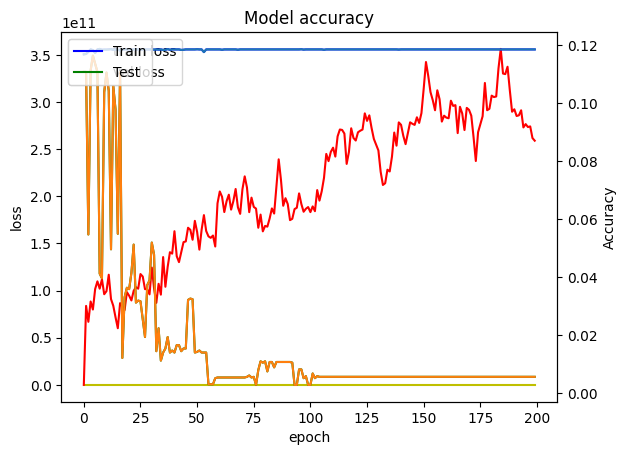

In [40]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

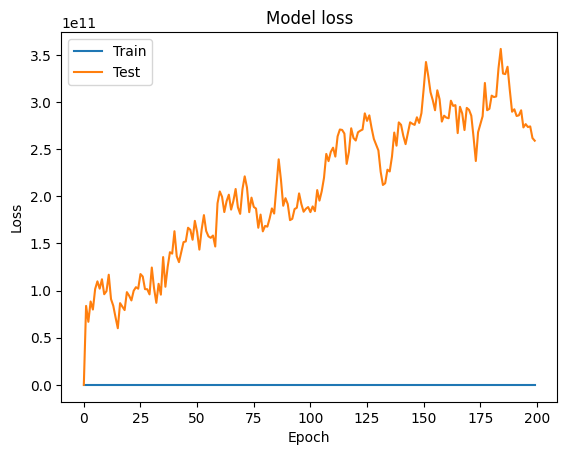

In [41]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
test_image_paths = sorted(
    list(
        paths.list_images("test/")
    )
)
print(">>> test image path =", test_image_paths)

>>> test image path = ['test/타이레놀.jpeg', 'test/기타의 비뇨생식기관 및 항문용약18.png', 'test/비타민 C 및 P제1.png']


In [56]:
for image_path in test_image_paths:
    test_image = cv2.imread(image_path)

    test_image = cv2.resize(
        test_image, (180, 180)
    )
    cv2.imshow("result", test_image)

    test_image = test_image.astype("float") / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    proba = model.predict(test_image)[0]
    print(
        np.round(proba, 3)
    )
    idx = np.argmax(proba)
    print(">>> predict class =", mlb.classes_[idx])

1/1 [==============================] - 0s 22ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
>>> predict class = 부신호르몬제
1/1 [==============================] - 0s 23ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
>>> predict class = 부신호르몬제
1/1 [==============================] - 0s 21ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0

In [43]:
model.save("Phill.h5")